# Cleaning Modes With Rational Filters

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
import seaborn as sns
import scipy.signal as ss
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.ticker import MultipleLocator
from gwpy.timeseries import TimeSeries

In [3]:
import qnm
omega220 = qnm.modes_cache(s=-2,l=2,m=2,n=0)(a=0.692)[0]
omega221 = qnm.modes_cache(s=-2,l=2,m=2,n=1)(a=0.692)[0]

## GW150914

Download data

In [4]:
# !wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5
# !wget https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5

Set some parameters of GW150914

Load data

## Noise realisation

In [5]:
fsamp = 4*4096
delta_t = 1/fsamp
t0 = 1126259462.423
duration = 4
time = np.arange(duration*fsamp)*delta_t + t0

data_psd = TimeSeries.read('H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5', format='hdf5.gwosc').psd()


In [28]:
lower_freq = 10
fill_value = data_psd.value[abs(data_psd.frequencies.value-lower_freq).argmin()]
idx = data_psd.frequencies.value<lower_freq
data_psd.value[idx] = fill_value

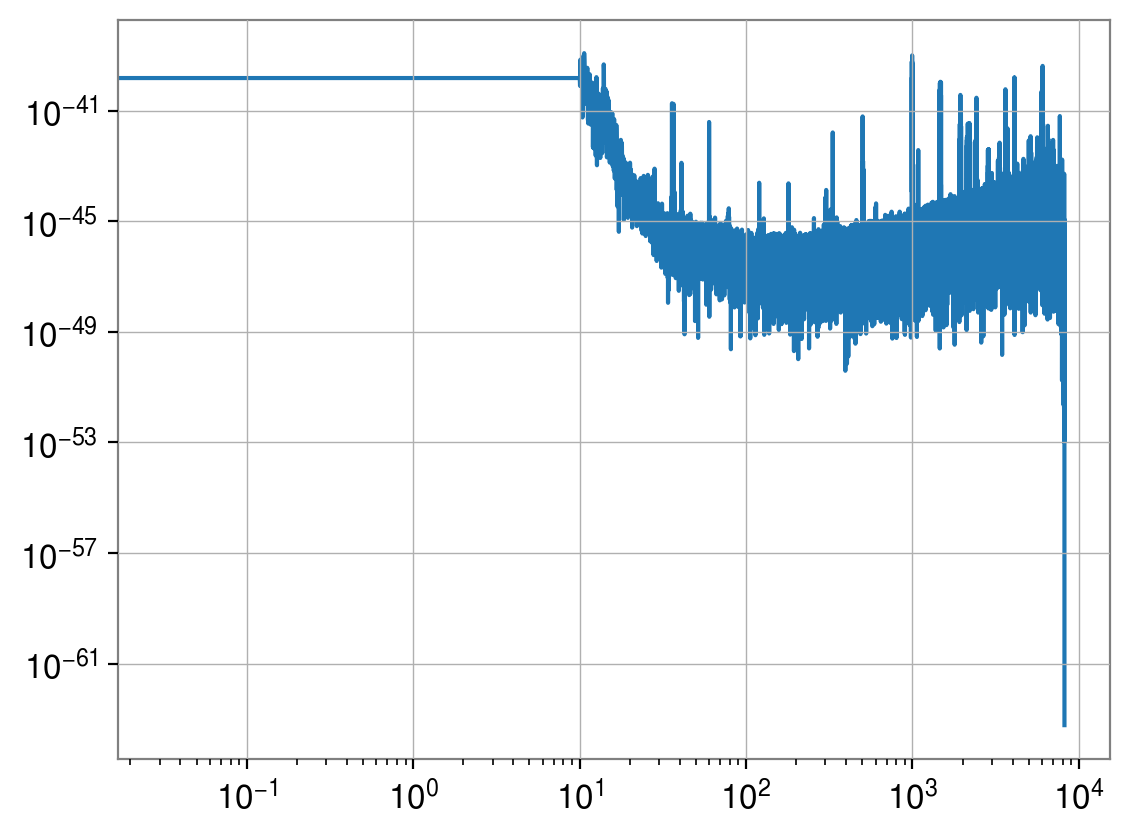

In [29]:
pl.loglog(data_psd)

In [30]:
qnm_noise = qnm_filter.Noise(freq=data_psd.frequencies, psd=data_psd.value)
ifo = qnm_filter.set_bilby_ifo(qnm_noise, sampling_frequency=fsamp, duration=duration, start_time=t0)
realisation = ifo.strain_data.time_domain_strain
realisation_freq, realisation_psd = ss.welch(realisation, fs=fsamp, nperseg=0.1*duration*fsamp)

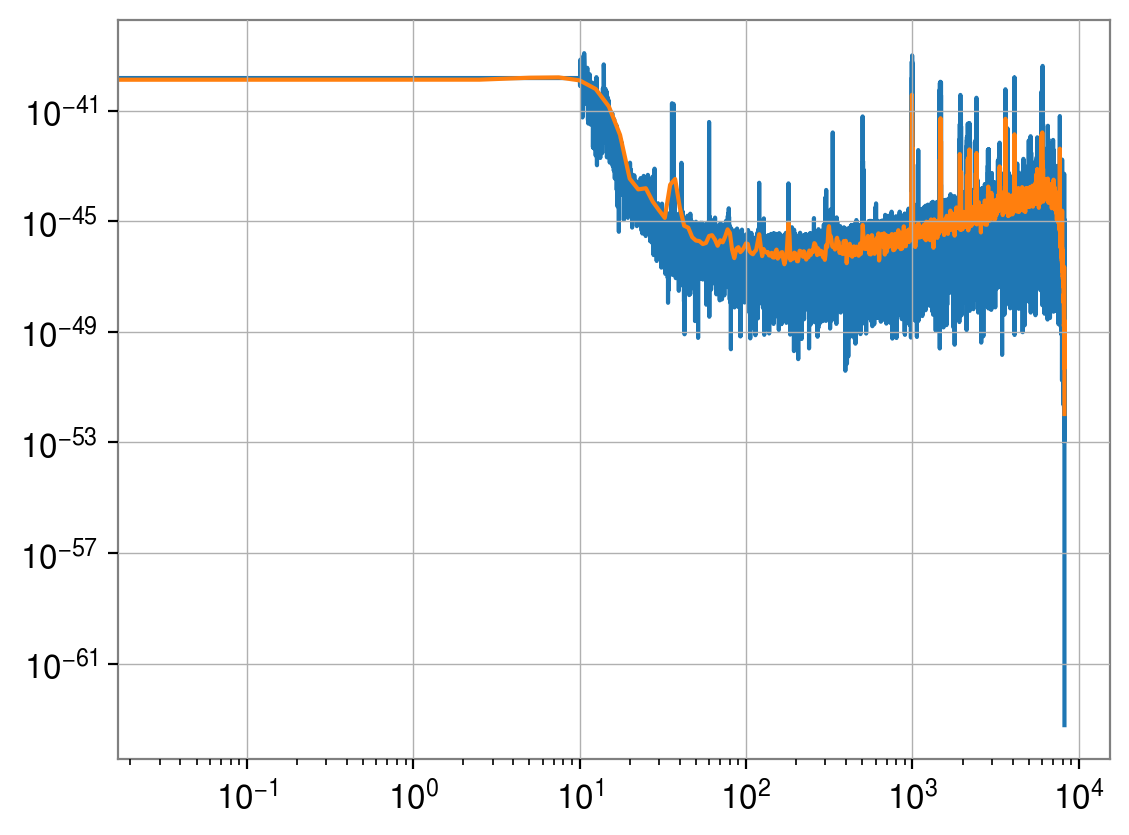

In [31]:
pl.loglog(data_psd)
pl.loglog(realisation_freq, realisation_psd)

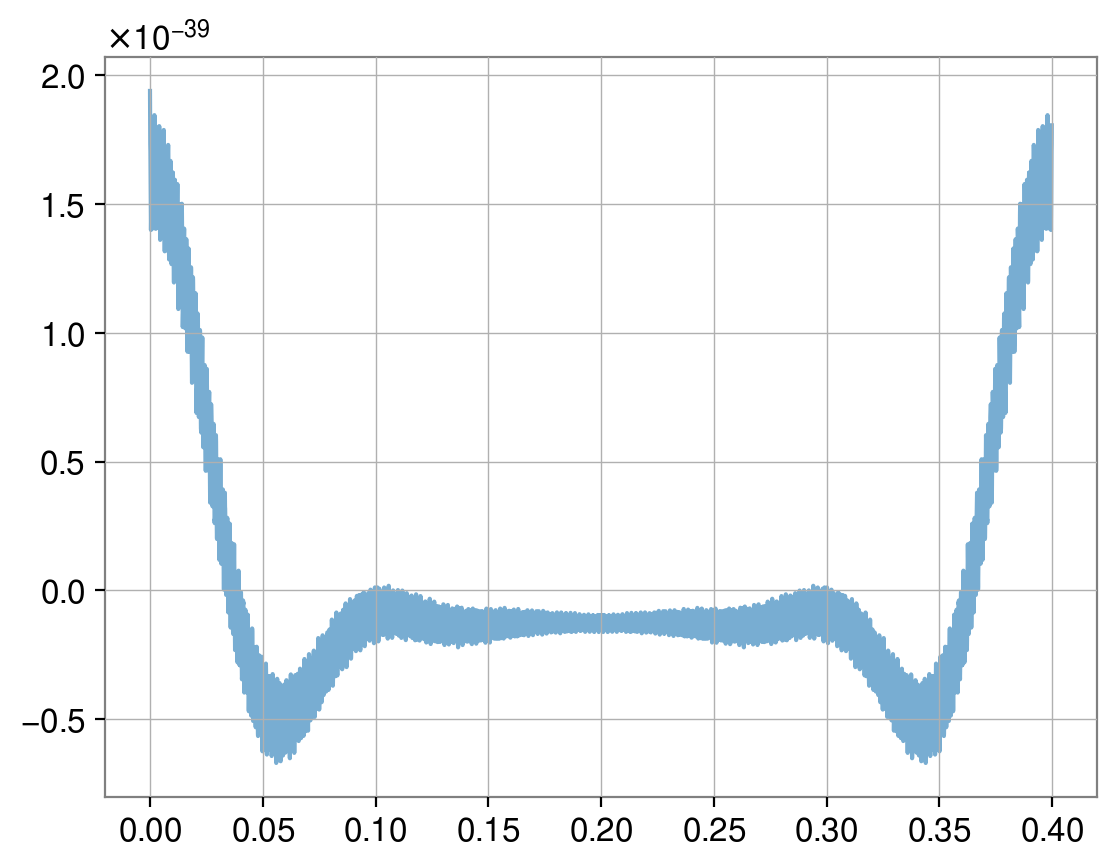

In [32]:
realisation_acf = 0.5*np.fft.irfft(realisation_psd) / delta_t
pl.plot(delta_t*np.arange(len(realisation_acf)), realisation_acf, alpha=0.6)

## qnm_filter

In [17]:
input = dict(model_list = [(2, 2, 0, 'p')], #l, m, n, prograde/retrograde
             # trucation time (geocenter, in second)
             t_init = 1126259462.423+0.02,
             # length of the analysis segment (in second)
             segment_length = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 2048,
             flow = 20)

fit = qnm_filter.Network(**input)

In [18]:
fit.original_data['H1'] = qnm_filter.RealData(realisation, index=time, ifo='H1')

<AxesSubplot: >

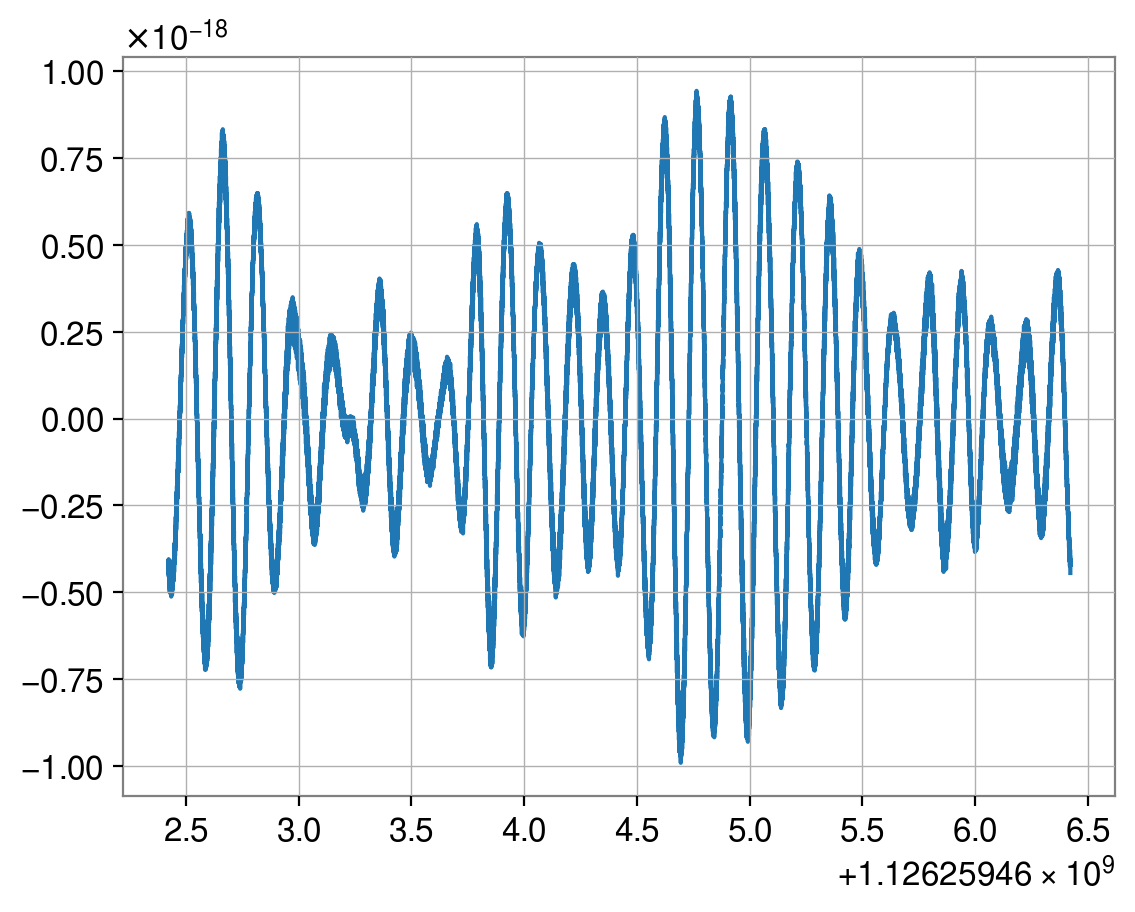

In [19]:
fit.original_data['H1'].plot()

Perform time alignment across detectors

Condition data 

In [20]:
fit.detector_alignment()
fit.condition_data('original_data', **input)

Cholesky-decomposition of the covariance matrix 

In [21]:
fit.compute_acfs('original_data')
fit.cholesky_decomposition()

<AxesSubplot: >

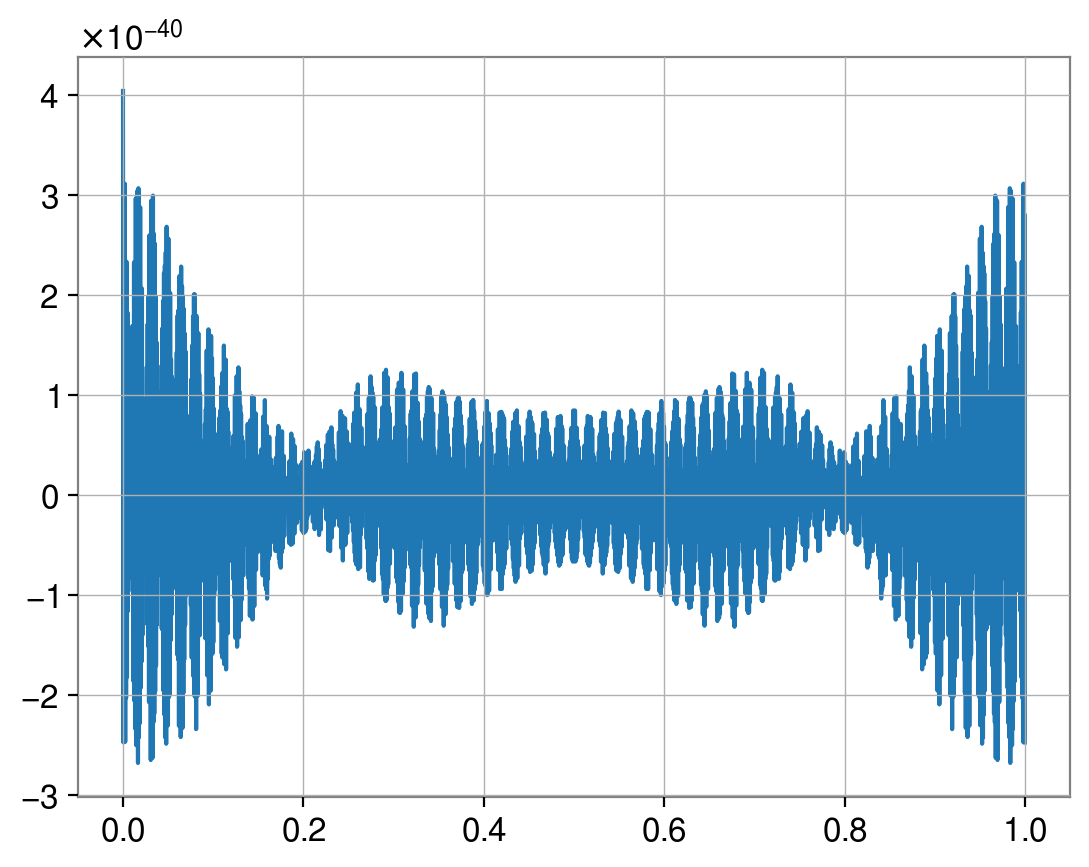

In [22]:
fit.acfs['H1'].plot()

## Likelihood as a function of mass and spin

Sampling remnant mass and spin

In [63]:
delta_mass = 2.0
delta_chi = 0.03
massspace = np.arange(34, 100, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

Interate over the samplings

In [64]:
fit.first_index()
likelihood_data, _ = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = -1, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data)

In [65]:
projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, delta_mass, delta_chi)

Plot 2d contours

Text(0, 0.5, '$\\chi_f$')

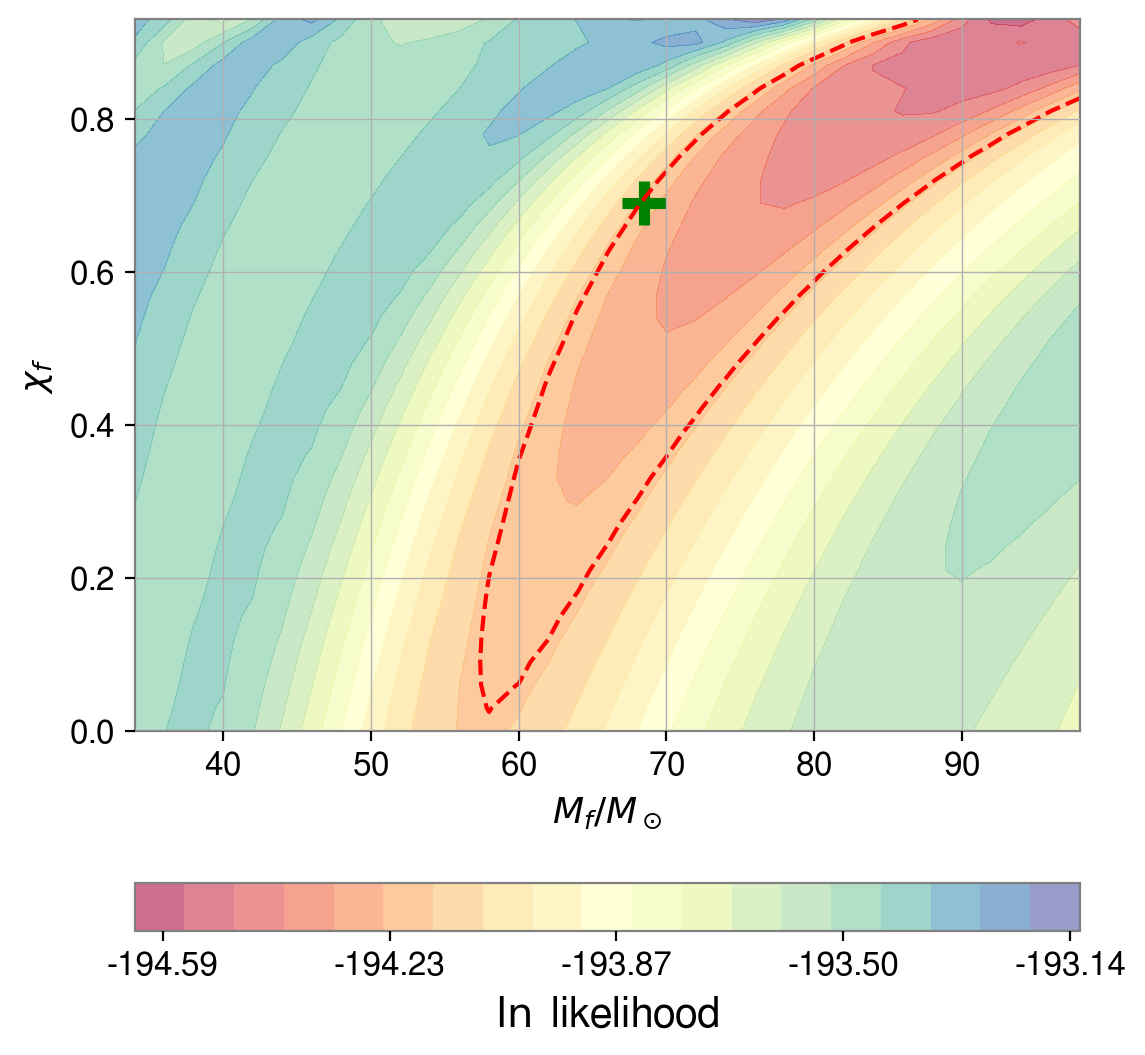

In [66]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=68.5, y=0.69, s=255, marker='+', 
           c='g', linewidths=4, label='IMR')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)

# ax.set_title(r'$\mathcal{F}_{220}+\mathcal{F}_{221}$')

With 1D side plots

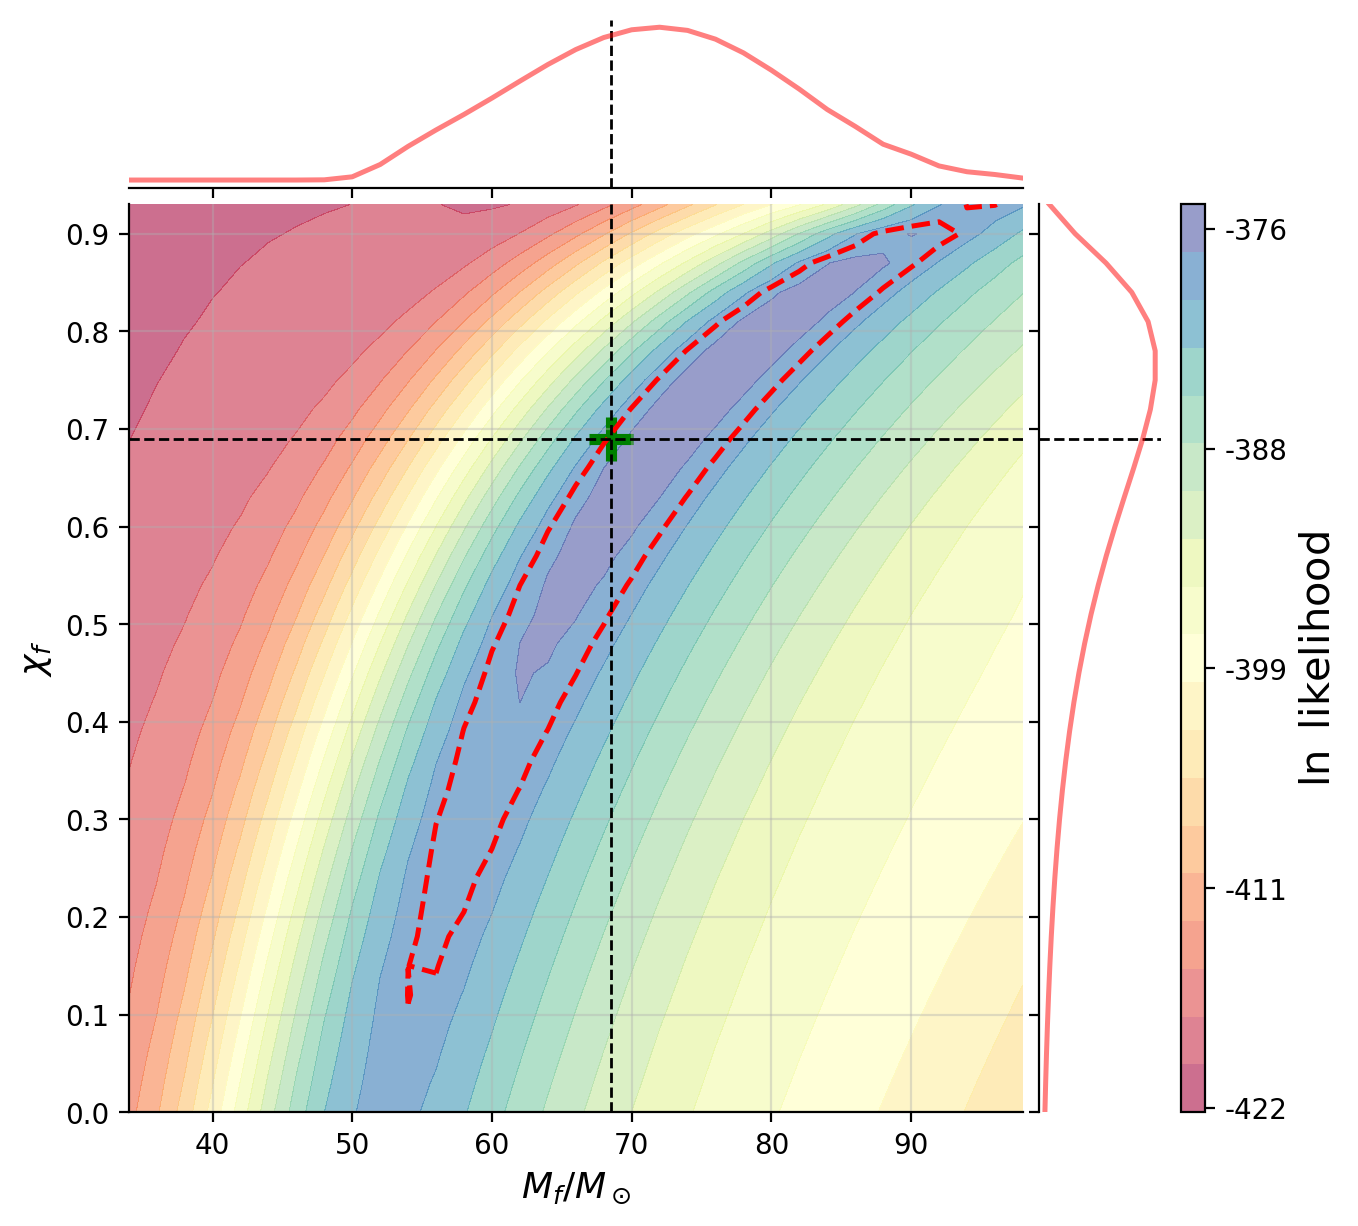

In [13]:
g = sns.JointGrid(ratio=5,space=0.1)

# 2D
contours=g.ax_joint.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
g.ax_joint.contour(contours, levels=[credible_region], linewidths=1.8,
                   linestyles='--', colors='red')
g.ax_joint.xaxis.set_major_locator(MultipleLocator(10))
g.ax_joint.yaxis.set_major_locator(MultipleLocator(0.1))
g.ax_joint.scatter(x=68.5, y=0.69, s=255, marker='+', 
                   c='g', linewidths=4, label='IMR')
g.ax_joint.axvline(68.5, ls='--', lw=1, c='k')
g.ax_joint.axhline(0.69, ls='--', lw=1, c='k')
g.ax_joint.set_xlabel(r'$M_f/M_\odot$', fontsize=13)
g.ax_joint.set_ylabel(r'$\chi_f$', fontsize=13)
g.ax_joint.grid(alpha=0.4)

# 1D side plots 
g.ax_marg_x.axvline(68.5, ls='--', lw=1, c='k')
g.ax_marg_x.plot(massspace, projected_mass, color='r', lw=1.8, alpha=0.5)

g.ax_marg_y.axhline(0.69, ls='--', lw=1, c='k')
g.ax_marg_y.plot(projected_chi, chispace, color='r',lw=1.8,alpha=0.5)

# coloarbar
divider = make_axes_locatable(g.ax_marg_y)
cax = divider.append_axes('right', size='20%', pad=0.1)
cbar=g.fig.colorbar(contours, cax=cax, orientation="vertical", format='%3.0f', ax=g.ax_marg_y)
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))